Training the model that takes the complete sequence and the evaluation calculates AUCs on separate task IDs. <br>
Evaluation method stays the same as separate_models.ipynb

In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

This code can work with tf.VERSION = '1.4.1' (for MacOS High Sierra); functions may change for other versions.

Model Parameters:

In [2]:
training_set_split = 0.8
validation_set_split = 0.1
#learning_rate = np.logspace(-5,0,5)
learning_rate = [0.01]
num_units = 50 #number of units in RNN cell
training_steps = 1000 #number of epochs (when convergence stopping not active)
display_step = 20 #number of epochs after which to display progress
optimize_using = "adam" #other option: "momentum", "adagrad", "adam"

In [3]:
print("Tensorflow version: " + str(tf.VERSION))

Tensorflow version: 1.4.1


Loading JSON file into dictionary called 'student_vectors'

In [4]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

Collecting unique CCSSM labels and Task IDs

In [5]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


Creating 1-hot encoding for Task IDs and CCSSM Labels

In [7]:
#pre-processing for using MultiLabelBinarizer
temp_ids = []
for i in task_ids:
    temp_ids.append([i])

#generating encodings
enc = MultiLabelBinarizer()
task_ids_1hot = (enc.fit_transform(temp_ids)).astype(float)
task_ids_classes = enc.classes_
task_ids_dict = dict(zip(task_ids, task_ids_1hot))
# print("\n1-hot encoding for task IDs:")
# pp.pprint(task_ids_dict)

Generating input sequences of interactions to feed the network. Say we have 3 task IDs; here is an example of interaction vectors generated:
1. User correctly solves task 2 of label 3: [010   000]
2. User incorrectly solves task 1 of label 2: [000   100]

1-hot representation of task IDs: 
task ID 1: 1,0,0
task ID 2: 0,1,0
task ID 3: 0,0,1

In [98]:
sequences = []
output_y_taskid = []
output_y = []
seqlen = []
incorrect_tid_vec = np.zeros((len(task_ids)), dtype=np.float)
for i in student_vectors:
    temp_seq = []
    temp_seq.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec])) #for taking first prediction into account
    for j in student_vectors[i]:
        if(j['second_try'] == False): #ignoring second_try
            if(j['correct'] == True):
                vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                temp_seq.append(vec)
            else:
                vec = np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]])
                temp_seq.append(vec)
    if(len(temp_seq)>1):
        seqlen.append(len(temp_seq))
        last_one = temp_seq.pop() #remove last interaction vector
        sequences.append(temp_seq) #add it to x
        first_one = temp_seq.pop(0) #remove first interaction vector
        temp_seq.append(last_one)
        output_y.append(temp_seq) #concatenate with last vector, and append to output!
        output_y_taskid.append(temp_seq)
    
# print("Sample interaction vector: ")
# pp.pprint(sequences[0][0])
length_interaction_vector = 2*(len(task_ids)) #length of interaction vector

Finding maximum sequence length.

In [99]:
max_seqlen = max(seqlen)
print("Maximum sequence length: "+str(max_seqlen))

Maximum sequence length: 187


Padding the sequences according to maximum sequence length. Making padded sequences of shape: number of students, maximum sequence length, length of interaction vector.

In [102]:
padded_sequences = np.zeros(shape=(len(student_vectors),max_seqlen-1,length_interaction_vector),dtype=float)
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        padded_sequences[i][j] = sequences[i][j]
print("Sequences have been padded according to the maximum sequence length. Final shape: " + str(padded_sequences.shape))

padded_output = np.zeros(shape=(len(student_vectors),max_seqlen-1,length_interaction_vector),dtype=float)
for i in range(len(output_y)):
    for j in range(len(output_y[i])):
        padded_output[i][j] = output_y[i][j]
        
padded_output_taskid = np.zeros(shape=(len(student_vectors),max_seqlen-1,length_interaction_vector),dtype=float)
for i in range(len(output_y_taskid)):
    for j in range(len(output_y_taskid[i])):
        padded_output_taskid[i][j] = output_y_taskid[i][j]

Sequences have been padded according to the maximum sequence length. Final shape: (1255, 186, 20)


Split the data into training and testing sets. The code for random split is ready.<br>
Review: **Try using sklearn**

In [103]:
#split = round((training_set_split+validation_set_split)*len(student_vectors))
split = round((training_set_split)*len(student_vectors))

tmp_rnd = 0
training_x = np.zeros_like(padded_sequences[:split])
training_y = np.zeros_like(np.asarray(padded_output)[:split])
training_y_taskid = np.zeros_like(np.asarray(padded_output_taskid)[:split])
training_seqlen = np.zeros_like(seqlen[:split])

test_x = np.zeros_like(padded_sequences[split:])
test_y = np.zeros_like(np.asarray(padded_output)[split:])
test_y_taskid = np.zeros_like(np.asarray(padded_output_taskid)[split:])
test_seqlen = np.zeros_like(seqlen[split:])

itr = 0
itr_tr = 0
itr_te = 0
# import random
# #separating training and testing sets randomly
# for i in range(len(padded_sequences)):
#     if(random.uniform(0, 1) <= (training_set_split+validation_set_split) and itr_tr < split):
#         #add to training
#         training_x[itr_tr] = padded_sequences[itr]
#         training_y[itr_tr] = np.asarray(padded_output)[itr]
#         training_y_taskid[itr_tr] = np.asarray(padded_output_taskid)[itr]
#         training_seqlen[itr_tr] = seqlen[itr]
#         itr_tr = itr_tr + 1
#     elif(itr_te < (len(student_vectors) - split)):
#         #add to testing
#         test_x[itr_te] = padded_sequences[itr]
#         test_y[itr_te] = np.asarray(padded_output)[itr]
#         test_y_taskid[itr_te] = np.asarray(padded_output_taskid)[itr]
#         test_seqlen[itr_te] = seqlen[itr]
#         itr_te = itr_te + 1
#     else:
#         #add to training
#         training_x[itr_tr] = padded_sequences[itr]
#         training_y[itr_tr] = np.asarray(padded_output)[itr]
#         training_y_taskid[itr_tr] = np.asarray(padded_output_taskid)[itr]
#         training_seqlen[itr_tr] = seqlen[itr]
#         itr_tr = itr_tr + 1
#     itr = itr + 1

#separating training & validation set
training_x = padded_sequences[:split]
training_y = np.asarray(padded_output)[:split]
training_y_taskid = np.asarray(padded_output_taskid)[:split]
training_seqlen = seqlen[:split]

#separating test set
test_x = padded_sequences[split:]
test_y = np.asarray(padded_output)[split:]
test_y_taskid = np.asarray(padded_output_taskid)[split:]
test_seqlen = seqlen[split:]

# #generating validation and training sets by implementing k-fold cross validation (k = maximum_position)
# validation_set_size = math.floor(validation_set_split * len(student_vectors))
# training_set_size = len(training_x) - validation_set_size
# maximum_position = math.floor(len(training_x) / validation_set_size)

# def get_next_train_valid_set(position):
#     if(position>=maximum_position):
#         position = position % maximum_position
#     print("Picking validation set from position: "+str(position))
#     valid_start = position*validation_set_size
#     valid_end = valid_start + validation_set_size
    
#     valid_set_x = training_x[valid_start : valid_end]
#     valid_set_y = training_y[valid_start : valid_end]
#     valid_set_y_taskid = np.asarray(training_y_taskid)[valid_start : valid_end]
#     valid_set_seqlen = np.asarray(training_seqlen[valid_start:valid_end])
    
#     train_set_x = np.concatenate((training_x[:valid_start], training_x[valid_end:]))
#     train_set_y = np.concatenate((training_y[:valid_start], training_y[valid_end:]))
#     train_set_y_taskid = np.concatenate((np.asarray(training_y_taskid)[:valid_start], np.asarray(training_y_taskid)[valid_end:]))
#     train_set_seqlen = np.concatenate((np.asarray(training_seqlen)[:valid_start],np.asarray(training_seqlen)[valid_end:]))
    
#     if(len(train_set_x) != training_set_size): #test
#         print("that's not good it is:")
#         print(train_set_x.shape)
    
#     return (train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_taskid)

# print("Splitting "+str(len(student_vectors))+" rows randomly into "+str(training_set_size)+ " for training, "+str(validation_set_size)+" for validation and "+str(len(test_x)) + " for testing.")
# print("Implemented "+str(maximum_position)+"-fold cross validation.")
print("Splitting "+str(len(student_vectors))+" rows (or students) into "+str(training_set_size)+ " for training and "+str(len(test_x)) + " for testing.")

Splitting 1255 rows (or students) into 1005 for training and 251 for testing.


Building the model

In [137]:
tf.reset_default_graph()
tf.set_random_seed(1234)
#defining placeholders
x = tf.placeholder(tf.float32, [None, max_seqlen-1, length_interaction_vector])
y = tf.placeholder(tf.float32, [None, max_seqlen-1, length_interaction_vector])
y_taskid = tf.placeholder(tf.float32, [None, max_seqlen-1, length_interaction_vector])
seqlen_tf = tf.placeholder(tf.float32,[None])

#defining tensorflow variables
learning_tf_rate = tf.Variable(0.0, name="learning_tf_rate",dtype=tf.float32,trainable=False)

#dynamic RNN definition
def dynamicRNN(x):
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
    out_size = int(length_interaction_vector / 2)
    outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    opposites = tf.subtract(tf.ones(tf.shape(outputs)),outputs)
    outputs1 = tf.concat([outputs,opposites],2)
    return outputs1

#making predictions
pred = dynamicRNN(x)
    
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_tf_rate).minimize(cost)
    

# Evaluate model - use AUC to evaluate model
auc_train,  opts_train = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_1,  opts_train_1 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_2,  opts_train_2 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_3,  opts_train_3 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_4,  opts_train_4 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_5,  opts_train_5 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_6,  opts_train_6 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_7,  opts_train_7 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_8,  opts_train_8 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_9,  opts_train_9 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_train_10,  opts_train_10 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test,  opts_test = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_1,  opts_test_1 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_2,  opts_test_2 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_3,  opts_test_3 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_4,  opts_test_4 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_5,  opts_test_5 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_6,  opts_test_6 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_7,  opts_test_7 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_8,  opts_test_8 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_9,  opts_test_9 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')
auc_test_10,  opts_test_10 = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')


Partitioning test set into separate task IDs

In [118]:
test_x_list_dict = {}
test_y_list_dict = {}
test_y_taskid_list_dict = {}
test_seqlen_list_dict = {}
train_x_list_dict = {}
train_y_list_dict = {}
train_y_taskid_list_dict = {}
train_seqlen_list_dict = {}
split = round((training_set_split)*len(student_vectors))
for i in another_2: 
    #generate encoding here! 
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        interactions.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec])) #for getting the first prediction!
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                    interactions.append(vec)
                else:
                    interactions.append(np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]]))
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            
    #add padding
    padded_sequences = np.zeros([len(sequences),max_seqlen,length_interaction_vector])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
    test_x_list_dict[i] = padded_sequences[split:,:-1]
    test_y_list_dict[i] = padded_sequences[split:,1:]
    test_y_taskid_list_dict[i] = padded_sequences[split:,1:]
    test_seqlen_list_dict[i] = sequences_lengths[split:]
    train_x_list_dict[i] = padded_sequences[:split,:-1]
    train_y_list_dict[i] = padded_sequences[:split,1:]
    train_y_taskid_list_dict[i] = padded_sequences[:split,1:]
    train_seqlen_list_dict[i] = sequences_lengths[:split]

In [140]:
test_y_list_dict

{'1zsCldT4p8.set1': array([[[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0.,

Training the Model

In [139]:
with tf.Session() as sess:
    plot_train_AUC = {}
    plot_train_AUC['overall'] = []
    plot_test_AUC = {}
    plot_test_AUC['overall'] = []
    for i in another_2:
        plot_train_AUC[i] = []
        plot_test_AUC[i] = []
    for l_r in learning_rate:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        cost_prev = 1.0
        stop = False
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        step = 0
        while(stop==False):
        #for step in range(1, training_steps):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
            step += 1
            if step % display_step == 0 or step == 1:
                loss= sess.run(cost, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                cost_current = loss
                if cost_prev - cost_current <= 0.00005:
                    stop = True
                else:
                    cost_prev = cost_current
    
                #calculate training AUC
                o_train_auc_taskid, o_train_opts_taskid = sess.run([auc_train, opts_train], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                #print("Train_auc_taskid: " + str(train_opts_taskid))

                # Calculate test auc
                o_temp_auc_taskid, o_temp_opts_taskid = sess.run([auc_test, opts_test], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid, seqlen_tf: test_seqlen})
                #print("Over-all testing auc for taskid: " + str(temp_opts_taskid))
                #Calculate test AUC on all task IDs
                
                #print status
                print("Epoch " + str(step) + ", Loss = " + str(loss) + ", Train AUC = "+str(o_train_opts_taskid) + ", Test AUC: "+str(o_temp_opts_taskid))
                plot_train_AUC['overall'].append(o_train_opts_taskid)
                plot_test_AUC['overall'].append(o_temp_opts_taskid)
                for idx,i in enumerate(another_2):
                    exec('temp_auc_taskid, temp_opts_taskid = sess.run([auc_test_'+str(idx+1)+', opts_test_'+str(idx+1)+'], feed_dict={x: test_x_list_dict[i], y: test_y_list_dict[i], y_taskid: test_y_taskid_list_dict[i],seqlen_tf: test_seqlen_list_dict[i]})')
                    exec('train_auc_taskid, train_opts_taskid = sess.run([auc_train_'+str(idx+1)+', opts_train_'+str(idx+1)+'], feed_dict={x: train_x_list_dict[i], y: train_y_list_dict[i], y_taskid: train_y_taskid_list_dict[i],seqlen_tf: train_seqlen_list_dict[i]})')
                    print(str(i) +" -> Train AUC: "+ str(train_opts_taskid) + ", Test AUC: "+str(temp_opts_taskid))
                    plot_train_AUC[i].append(train_opts_taskid)
                    plot_test_AUC[i].append(temp_opts_taskid)
                
                view_point = np.argsort(test_seqlen)[1]
                prediction = sess.run([pred], feed_dict={x: [test_x[view_point]], y: [test_y[view_point]], seqlen_tf: [test_seqlen[view_point]]})
                print("\n\ntrue:\n")
                print(test_x[view_point][:test_seqlen[view_point]])
                print("\n\nprediction\n")
                print(prediction[0][:test_seqlen[view_point]])
                print("\n\n")
            
        print("Optimization Finished!")

Final Learning Rate: 0.01
Epoch 1, Loss = 0.9654974, Train AUC = 0.82486606, Test AUC: 0.7985839
p7cfRPp-kQ.partb -> Train AUC: 0.8865044, Test AUC: 0.86836445
Ok-iIHxjgx.partb -> Train AUC: 0.63860506, Test AUC: 0.0
1zsCldT4p8.set1 -> Train AUC: 0.81774366, Test AUC: 0.75054
DebcfZEEmI.proper_fractions -> Train AUC: 0.80237925, Test AUC: 0.84534585
9wRCzK1G7F.partb -> Train AUC: 0.8190758, Test AUC: 0.87393486
1zsCldT4p8.set2 -> Train AUC: 0.89724284, Test AUC: 0.8502765
nl-M69Ez9k.parta -> Train AUC: 0.82207185, Test AUC: 0.0
kvig7fcCVc.partb -> Train AUC: 0.9408568, Test AUC: 0.0
Ok-iIHxjgx.parta -> Train AUC: 0.88031316, Test AUC: 0.0
hyei4uD81i.parta -> Train AUC: 0.5686696, Test AUC: 0.0


true:

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0

Epoch 80, Loss = 0.96135885, Train AUC = 0.9405968, Test AUC: 0.93710226
p7cfRPp-kQ.partb -> Train AUC: 0.8696867, Test AUC: 0.8516981
Ok-iIHxjgx.partb -> Train AUC: 0.6730355, Test AUC: 0.0
1zsCldT4p8.set1 -> Train AUC: 0.78792375, Test AUC: 0.7416973
DebcfZEEmI.proper_fractions -> Train AUC: 0.7945829, Test AUC: 0.812689
9wRCzK1G7F.partb -> Train AUC: 0.78359205, Test AUC: 0.82728136
1zsCldT4p8.set2 -> Train AUC: 0.80285454, Test AUC: 0.7462113
nl-M69Ez9k.parta -> Train AUC: 0.7992184, Test AUC: 0.0
kvig7fcCVc.partb -> Train AUC: 0.8565225, Test AUC: 0.0
Ok-iIHxjgx.parta -> Train AUC: 0.8679206, Test AUC: 0.0
hyei4uD81i.parta -> Train AUC: 0.57182187, Test AUC: 0.0


true:

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


1zsCldT4p8.set2 -> Train AUC: 0.77441794, Test AUC: 0.71658134
nl-M69Ez9k.parta -> Train AUC: 0.797879, Test AUC: 0.0
kvig7fcCVc.partb -> Train AUC: 0.8415832, Test AUC: 0.0
Ok-iIHxjgx.parta -> Train AUC: 0.87603736, Test AUC: 0.0
hyei4uD81i.parta -> Train AUC: 0.56917834, Test AUC: 0.0


true:

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

Text(0.5,1,'OVERALL')

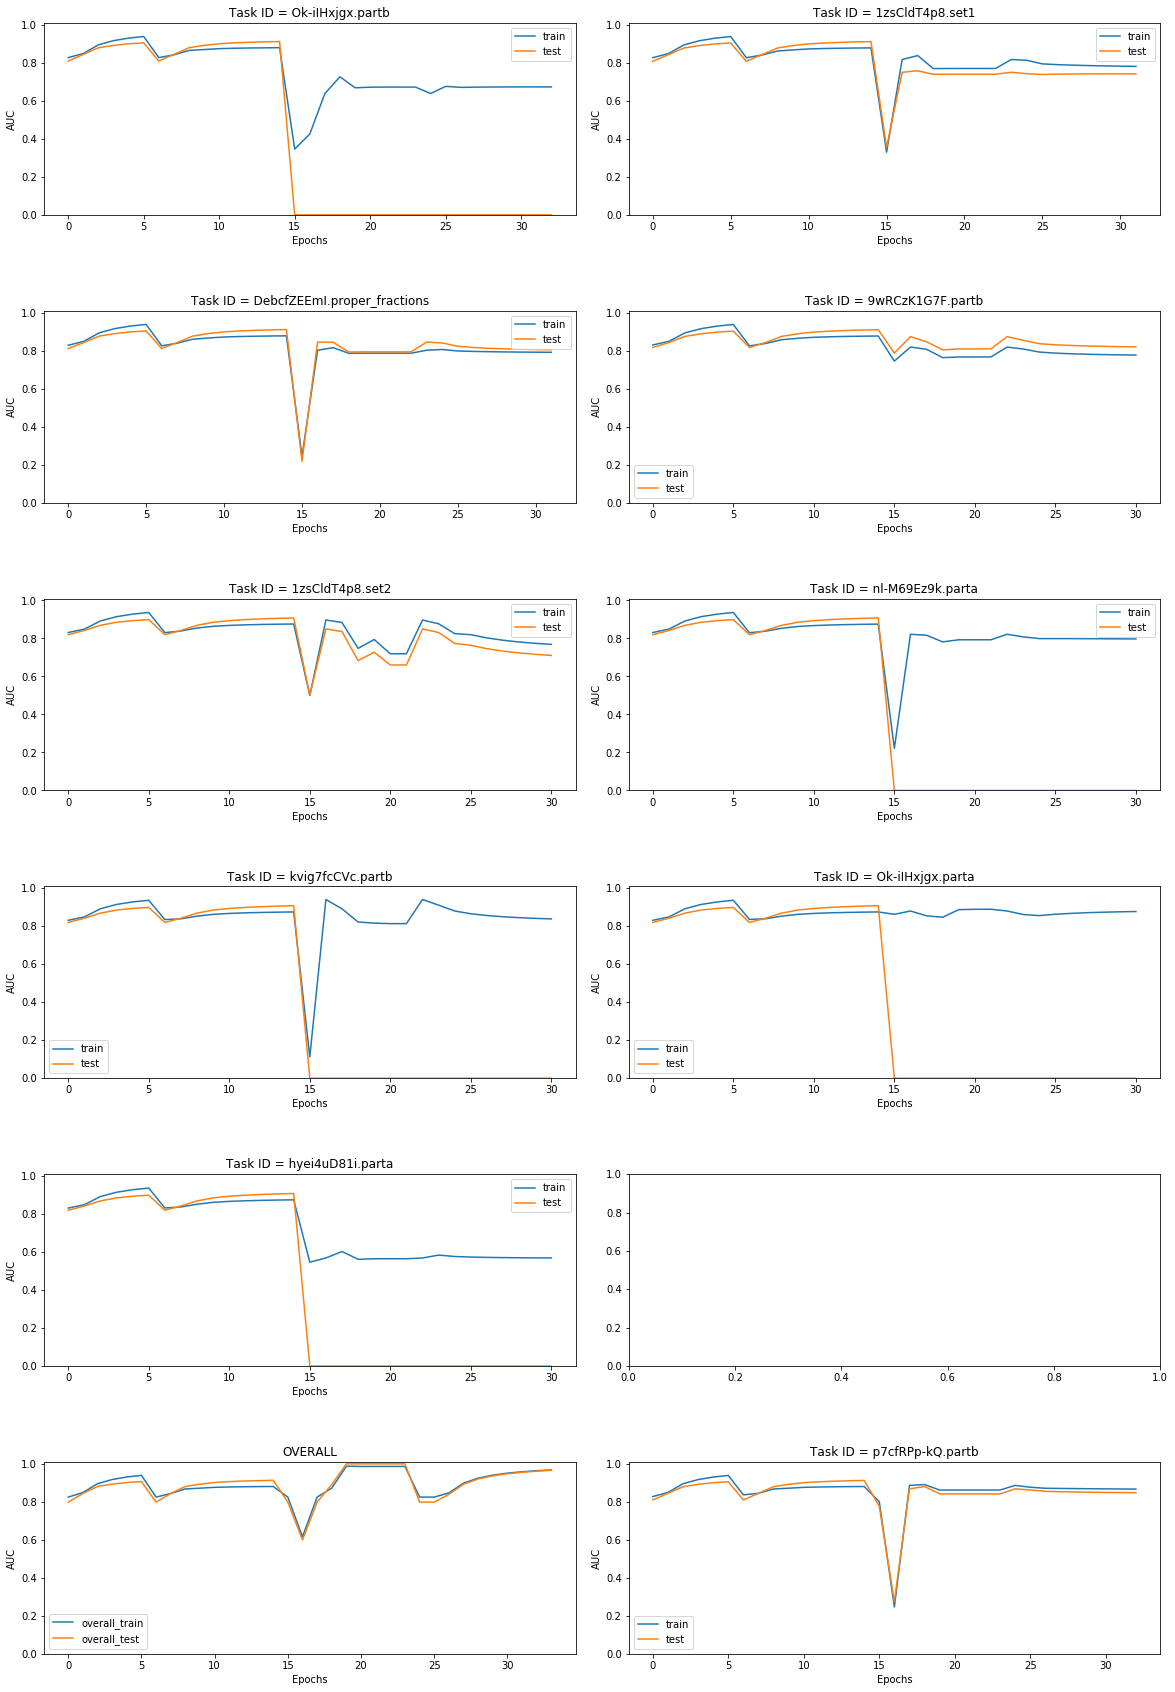

In [141]:
fig, axs = plt.subplots(6,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    axs[i-1].plot(plot_train_AUC[value],label='train')
    axs[i-1].plot(plot_test_AUC[value],label='test')
    axs[i-1].set_ylim(0,1.01)
    axs[i-1].set_xlabel("Epochs")
    axs[i-1].set_ylabel("AUC")
    axs[i-1].legend(loc="best")
    axs[i-1].set_title("Task ID = "+str(value))
    
axs[i+1].plot(plot_train_AUC['overall'],label='overall_train')
axs[i+1].plot(plot_test_AUC['overall'],label='overall_test')
axs[i+1].set_ylim(0,1.01)
axs[i+1].set_xlabel("Epochs")
axs[i+1].set_ylabel("AUC")
axs[i+1].legend(loc="best")
axs[i+1].set_title("OVERALL")

**No longer maintained below this point.**<br>Training the model for hyperparameter (learning rate) tuning.

In [ ]:
# plot_lr = []
# plot_valid_auc_taskid = []
# plot_train_auc_taskid = []

# with tf.Session() as sess:
#     for l_r in learning_rate:
#         plot_lr.append(l_r)    
#         valid_taskid_list = []
#         for k_fold in range(1,maximum_position+1):
#             # Initialize the variables (i.e. assign their default value)
#             tf.reset_default_graph()
#             print(str(k_fold)+"-fold cross-validation")
#             sess.run(tf.global_variables_initializer())
#             sess.run(tf.local_variables_initializer())
#             assign_op = learning_tf_rate.assign(l_r)
#             sess.run(assign_op)
#             print("Current Learning Rate: "+str(learning_tf_rate.eval()))
#             train_set_seqlen, valid_set_seqlen, valid_set_x, valid_set_y, valid_set_y_taskid, train_set_x, train_set_y, train_set_y_taskid = get_next_train_valid_set(k_fold-1)
            
#             for step in range(1, training_steps+1):
#                 batch_x = train_set_x
#                 batch_y = train_set_y
#                 sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})

#                 if step % display_step == 0 or step == 1:
#                     loss,trainAUC,trainOPTS = sess.run([cost, auc, opts], feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})
#                     #print status
#                     print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()) + ", Train AUC:" + str(trainOPTS))
#             #calculate validation AUC
#             valid_auc_taskid, valid_opts_taskid = sess.run([auc, opts], feed_dict={x: valid_set_x, y: valid_set_y, y_taskid: valid_set_y_taskid, seqlen_tf: valid_set_seqlen})
#             print("Valid_auc_taskid: " + str(valid_opts_taskid) + " with k = "+str(k_fold))
#             valid_taskid_list.append(valid_opts_taskid)
#             print("Optimization Finished!")
    
#         #calculate training AUC (it should take both validation and training sets)
#         train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})

#         print("Train_auc_taskid: " + str(train_opts_taskid))
#         plot_train_auc_taskid.append(train_opts_taskid)
        
#         #take average of validation AUCs
#         valid_avg_taskid = np.mean(valid_taskid_list)
        
#         print("Average Valid_auc_taskid: " + str(valid_avg_taskid))
#         plot_valid_auc_taskid.append(valid_avg_taskid)

Plotting validation set ccssm auc across different learning rates.

In [ ]:
# plt.title("Training Set AUC")
# plt.xlabel("Learning Rate Index")
# plt.ylabel("AUC")
# plt.plot(plot_train_auc_taskid,'r--',label='train')
# plt.plot(plot_valid_auc_taskid,label='valid')
# plt.legend(loc='best', fancybox=True, framealpha=0.5)
# plt.show()
# print(learning_rate)

#http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/